# Calculating Upwelling/Downwelling Spectral Intensity with PyARTS

In [1]:
%load_ext autoreload
%autoreload 2
!conda install -c conda-forge -y pint-xarray

import os
import warnings
warnings.filterwarnings('ignore')

if os.path.isdir('/share/share/ESCI345'):
    os.environ["ARTS_DATA_PATH"] = "/share/share/ESCI345/"
    os.environ["ARTS_XML_ATMO"] = "/share/share/ESCI345/atmospheres/"
else:
    os.environ["ARTS_DATA_PATH"] = "/Users/wgblumbe/Code/rttools/arts_catalogs/arts-cat-data-snapshot-arts-2.5.8/"
    os.environ["ARTS_XML_ATMO"] = "/Users/wgblumbe/Code/rttools/ESCI345/atmospheres/"

import pint
ureg = pint.UnitRegistry()

import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import re
import optical_depth
import rtcalc_module
import pandas as pd

pplt.use_style("seaborn-talk")
pplt.rc["legend.facecolor"] = "white"



def tag2tex(tag):
    """Replace all numbers in a species tag with LaTeX subscripts."""
    return re.sub("([a-zA-Z]+)([0-9]+)", r"\1$_{\2}$", tag)

## Section 1: Calculate upwelling/downwelling spectra.
### Step 1. Using PyARTS to find gas optical depths for an atmosphere.

Below includes code to set up the spectral region (IR is used here) and select one of the FASCODE atmospheres to calculate our gas optical depths.  The absorption species used in these calculation are the usual suspects for IR absorption.

In [2]:
freq_bounds = (20 * pint.Unit("micrometers"), 6 * pint.Unit("micrometers"))
atmosphere = 'subarctic-winter' #midlatitude-summer, midlatitude-winter, subarctic-summer, subarctic-winter
profiles, optical_depths, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=atmosphere, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)
optical_depths

<xarray.DataArray (gas_species: 7, spectral_unit: 1000, layer_center: 49)>
array([[[1.26284489e-01, 1.21887568e-01, 1.16011367e-01, ...,
         3.50354929e-06, 3.21237952e-06, 0.00000000e+00],
        [3.19397359e-01, 3.08437869e-01, 2.93538416e-01, ...,
         7.19202545e-06, 6.58913697e-06, 0.00000000e+00],
        [3.43535922e+01, 3.43422114e+01, 3.37271693e+01, ...,
         9.25284991e-04, 8.46477192e-04, 0.00000000e+00],
        ...,
        [3.85352046e+00, 3.66777602e+00, 3.45321804e+00, ...,
         1.98701508e-04, 1.82393015e-04, 0.00000000e+00],
        [2.62936790e+00, 2.50516629e+00, 2.36066995e+00, ...,
         1.33288094e-04, 1.22346631e-04, 0.00000000e+00],
        [3.00144062e+00, 2.86946045e+00, 2.71360677e+00, ...,
         1.79091362e-04, 1.64705070e-04, 0.00000000e+00]],

       [[1.28862285e-05, 1.25101333e-05, 1.20450835e-05, ...,
         7.80208344e-08, 7.12947193e-08, 0.00000000e+00],
        [1.71437459e-05, 1.68536016e-05, 1.64183056e-05, ...,
         2.99301807e-07, 2.90975870e-07, 0.00000000e+00],
        [5.68581992e-06, 5.34130409e-06, 4.97461893e-06, ...,
         1.13855971e-08, 1.03902159e-08, 0.00000000e+00],
...
        [1.01045466e-05, 9.35890763e-06, 8.64923699e-06, ...,
         1.22744351e-07, 1.12070578e-07, 0.00000000e+00],
        [5.62450452e-04, 5.34009722e-04, 5.05607332e-04, ...,
         1.58399456e-05, 1.45562069e-05, 0.00000000e+00],
        [1.67077065e-04, 1.54455992e-04, 1.42363545e-04, ...,
         1.43437839e-06, 1.29709913e-06, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.41366846e-07, 1.28775762e-07, 1.17137912e-07, ...,
         1.39801621e-09, 1.27724534e-09, 0.00000000e+00],
        [2.29594559e-07, 2.09103549e-07, 1.90170606e-07, ...,
         2.25671603e-09, 2.06173496e-09, 0.00000000e+00],
        [1.02753411e-04, 1.00840137e-04, 9.86533410e-05, ...,
         8.92405946e-06, 8.32451425e-06, 0.00000000e+00]]])
Coordinates:
  * gas_species    (gas_species) <U3 'H2O' 'CO2' 'O3' 'N2O' 'CO' 'CH4' 'O2'
  * spectral_unit  (spectral_unit) float64 20.0 19.95 19.91 ... 6.008 6.004 6.0
  * layer_center   (layer_center) float64 179.1 537.3 ... 1.517e+04 1.548e+04

### Step 2. Solve the Radiative Transfer Equation (Schwarzschild's Equation) 

To solve the RTE for upwelling and downwelling atmospheres, we need to use Schwarzschild's Equation (no scattering), which needs the layer optical depths, and for any upwelling calculations, the surface temperature and emissivity.  We also need to know if our instrument detector (ground or space-based) is looking at zenith or any off-zenith angles.  This below code will use those parameters and calculate the spectra.  

In [ ]:
### Surface and instrument view angle parameters
zenith = 0
surface_temperature = profiles["Temperature"][0] # K
surface_emissivity = 1
###

wnum = freq.to("1/centimeter", "spectroscopy")
gas_opd = optical_depths.sum(axis=0).T

rad_dn = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = profiles['Temperature'].to_numpy(), zenith_angle=zenith)
rad_up = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = profiles['Temperature'].to_numpy(), upwelling=True, 
                          sfc_t=surface_temperature, sfc_e=surface_emissivity, zenith_angle=zenith)

### Step 3. Plot the spectral intensity.

In [ ]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(9,4))
for tb in [210,230,250,270,290,310]:  # Plot some curves to relate the intensity to brightness temperature.
    ax.plot(wnum, rtcalc_module.planck(wnum.magnitude, tb), 'r--', alpha=0.5, lw=1, label="")
ax.plot(wnum, rad_dn, label=r"Downwelling $I_\nu^\downarrow$", lw=1)
ax.plot(wnum, rad_up, label=r"Upwelling $I_\nu^\uparrow$", lw=1)

ax.format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Intensity [RU]", grid=True,
          suptitle=rf"Ground & Space-Based Spectral Intensity ({atmosphere}, $\theta=${zenith})")
ax.legend(loc='ur',ncol=1)
fig.save("plots/spectral_intensity.pdf")
plt.show()

### Step 4. Plot the brightness temperatures.

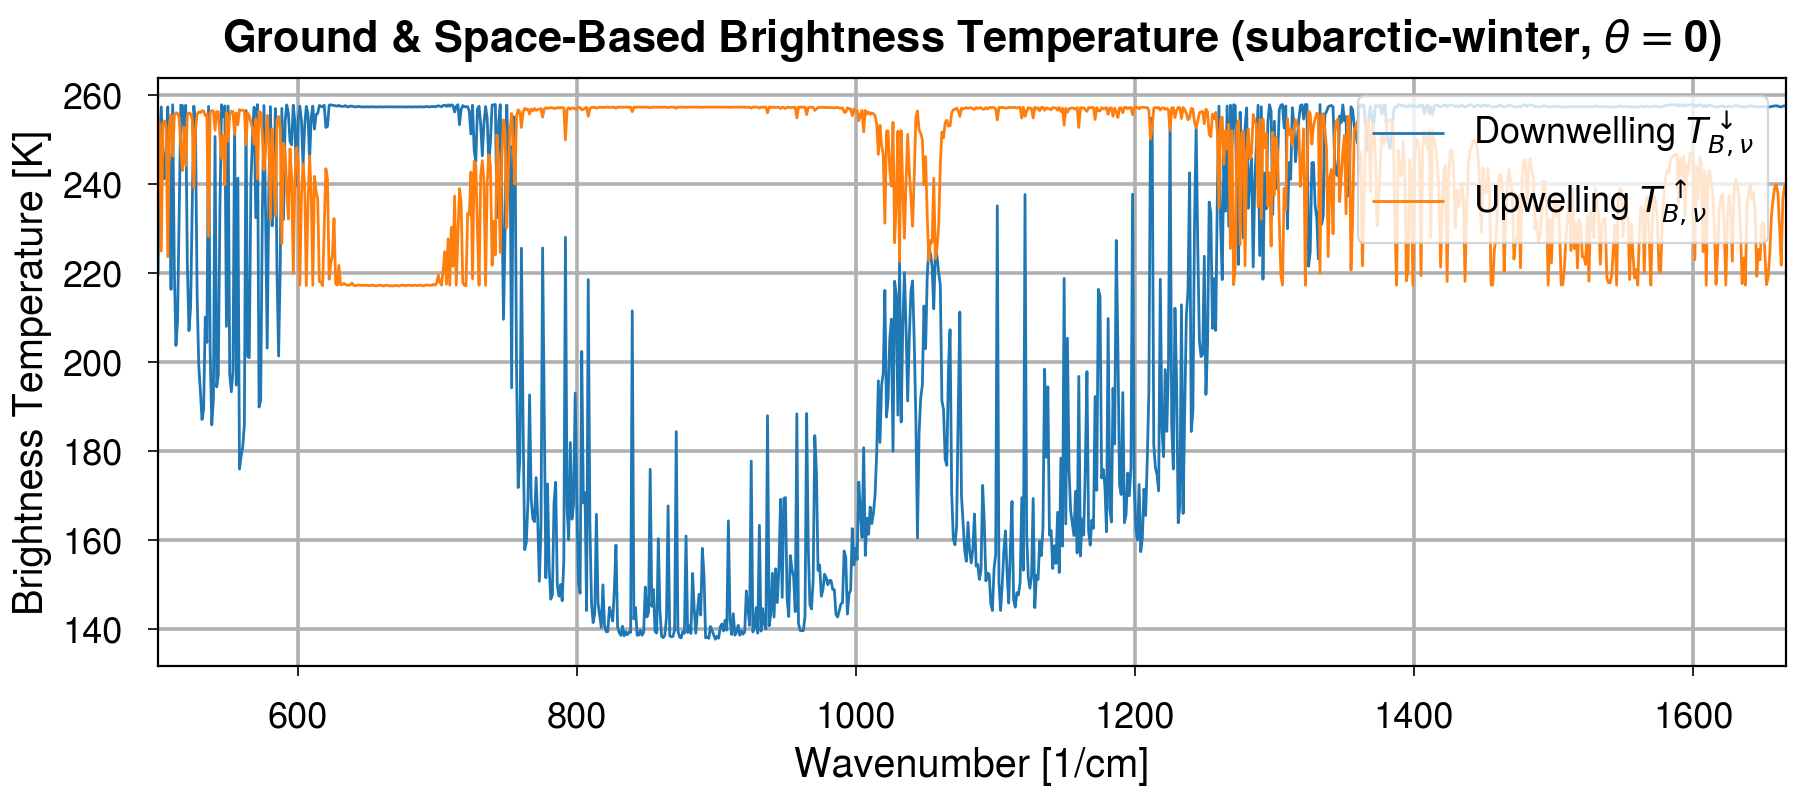

In [11]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(9,4))
ax.plot(wnum, rtcalc_module.brightness_temperature(rad_dn.magnitude, wnum.magnitude), label=r"Downwelling $T_{B,\nu}^\downarrow$", lw=1)
ax.plot(wnum, rtcalc_module.brightness_temperature(rad_up.magnitude, wnum.magnitude), label=r"Upwelling $T_{B,\nu}^\uparrow$", lw=1)

ax.format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Brightness Temperature [K]", grid=True,
          suptitle=rf"Ground & Space-Based Brightness Temperature ({atmosphere}, $\theta=${zenith})")
ax.legend(loc='ur',ncol=1)
fig.save("plots/spectral_tb.pdf")
plt.show()

## Section 2: Comparing spectra from different atmospheres

We use only 1000 elements on the spectral grid for speed (not accuracy).

Sometimes it can be very useful to compare the spectra from different atmospheres.  This section allows you to do just that.  We read in one of the FASCODE atmospheres (midlatitude-winter.csv) and compute the gas optical depths.  This will be our control atmosphere.  

Our experimental atmosphere (for the sake of simplicity) is to take the midlatitude winter atmosphere and double the amount of Ozone throughout the profile.  This should lead to more absorption in the portions of the IR spectra where there is absorption by ozone.

In [ ]:
freq_bounds = (20 * pint.Unit("micrometers"), 5 * pint.Unit("micrometers"))

# Read in our control atmosphere and compute the gas optical depths.
atmosphere = pd.read_csv(os.environ["ARTS_XML_ATMO"] + '/midlatitude-winter.csv')
profiles_ctl, optical_depths_ctl, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=atmosphere, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)

# Conduct an experiment where the ozone concentrations are doubled and we recompute the gas optical depths.
# You can also edit the CSV file (which has columns specifying the profile of the thermodynamics and gas concentrations) and read
# that file in.
#atmosphere = pd.read_csv(os.environ["ARTS_XML_ATMO"] + '/midlatitude-winter.csv')
atmosphere['O3'] *= 2 # double the ozone concentration
profiles_exp, optical_depths_exp, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=atmosphere, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)

### Set the surface and instrument view angle parameters
zenith = 0
surface_temperature = profiles["Temperature"][0] # K
surface_emissivity = 1
###

# Compute the gas optical depths and convert our spectral unit to wavenumber.
wnum = freq.to("1/centimeter", "spectroscopy")
gas_opd_ctl = optical_depths_ctl.sum(axis=0).T
gas_opd_exp = optical_depths_exp.sum(axis=0).T

### Calculate the upwelling and downwelling control and experiment spectra. ###
# Downwelling
rad_dn_ctl = rtcalc_module.rt(opd = gas_opd_ctl, wnum = wnum, temp = profiles_ctl['Temperature'].to_numpy(), zenith_angle=zenith)
rad_dn_exp = rtcalc_module.rt(opd = gas_opd_exp, wnum = wnum, temp = profiles_exp['Temperature'].to_numpy(), zenith_angle=zenith)

# Upwelling
rad_up_ctl = rtcalc_module.rt(opd = gas_opd_ctl, wnum = wnum, temp = profiles_ctl['Temperature'].to_numpy(), upwelling=True, 
                          sfc_t=surface_temperature, sfc_e=surface_emissivity, zenith_angle=zenith)

rad_up_exp = rtcalc_module.rt(opd = gas_opd_exp, wnum = wnum, temp = profiles_exp['Temperature'].to_numpy(), upwelling=True, 
                          sfc_t=surface_temperature, sfc_e=surface_emissivity, zenith_angle=zenith)

### Step 2: Plot the control and experiment space-based and ground-based spectra:

In [ ]:
fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(9,7), sharey=False, sharex=True)
fig.format(suptitle=rf"Space-Based Spectral Intensity ($\theta=${zenith})")
for tb in [210,230,250,270,290,310]:
    ax[0].plot(wnum, rtcalc_module.planck(wnum.magnitude, tb), 'r--', alpha=0.5, lw=1, label="")
#ax.plot(wnum, rad_up_ctl, label=r"Downwelling $I_\nu^\downarrow$")
ax[0].plot(wnum, rad_up_ctl, label=r"Cntl. Upwelling $I_\nu^\uparrow$", lw=1, alpha=0.8)
ax[0].plot(wnum, rad_up_exp, label=r"Exp. Upwelling $I_\nu^\uparrow$", lw=1, alpha=0.8)

ax[0].format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Intensity [RU]", grid=True)
ax[0].legend(loc='ur',ncol=1)

ax[1].plot(wnum, rad_up_exp - rad_up_ctl, lw=1)
ax[1].format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Experiment - Control [RU]", grid=True)

fig.save("plots/rt_experiment_up.pdf")
plt.show()

fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(9,7), sharey=False, sharex=True)
fig.format(suptitle=rf"Ground-Based Spectral Intensity ($\theta=${zenith})")
for tb in [210,230,250,270,290,310]:
    ax[0].plot(wnum, rtcalc_module.planck(wnum.magnitude, tb), 'r--', alpha=0.5, lw=1, label="")
#ax.plot(wnum, rad_up_ctl, label=r"Downwelling $I_\nu^\downarrow$")
ax[0].plot(wnum, rad_dn_ctl, label=r"Cntl. Downwelling $I_\nu^\downarrow$", lw=1, alpha=0.8)
ax[0].plot(wnum, rad_dn_exp, label=r"Exp. Downwelling $I_\nu^\downarrow$", lw=1, alpha=0.8)

ax[0].format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Intensity [RU]", grid=True)
ax[0].legend(loc='ur',ncol=1)

ax[1].plot(wnum, rad_dn_exp - rad_dn_ctl, lw=1)
ax[1].format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Experiment - Control [RU]", grid=True)

fig.save("plots/rt_experiment_dn.pdf")
plt.show()